# MSDS Thesis
## Data Analysis in Python for olfactoneuroimaging data

Apoorv Saraogee MSDS 599 - Dr. Srinivasan

In [2]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

import nibabel as nib
import nilearn.plotting as plotting
from nilearn.image import mean_img
import glob

from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

# Set FSL environment variables
os.environ['FSLDIR'] = '/Users/asaraog/fsl'
os.environ['FSLOUTPUTTYPE'] = 'NIFTI_GZ'
os.environ['PATH'] += os.pathsep + os.path.join(os.environ['FSLDIR'], 'bin')
# Define file paths and parameters
data_dir = 'ds002185-download'

2024-08-27 16:37:28.489095: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## EDA on the standard neuroimaging preprocessing steps for one subjects run

/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



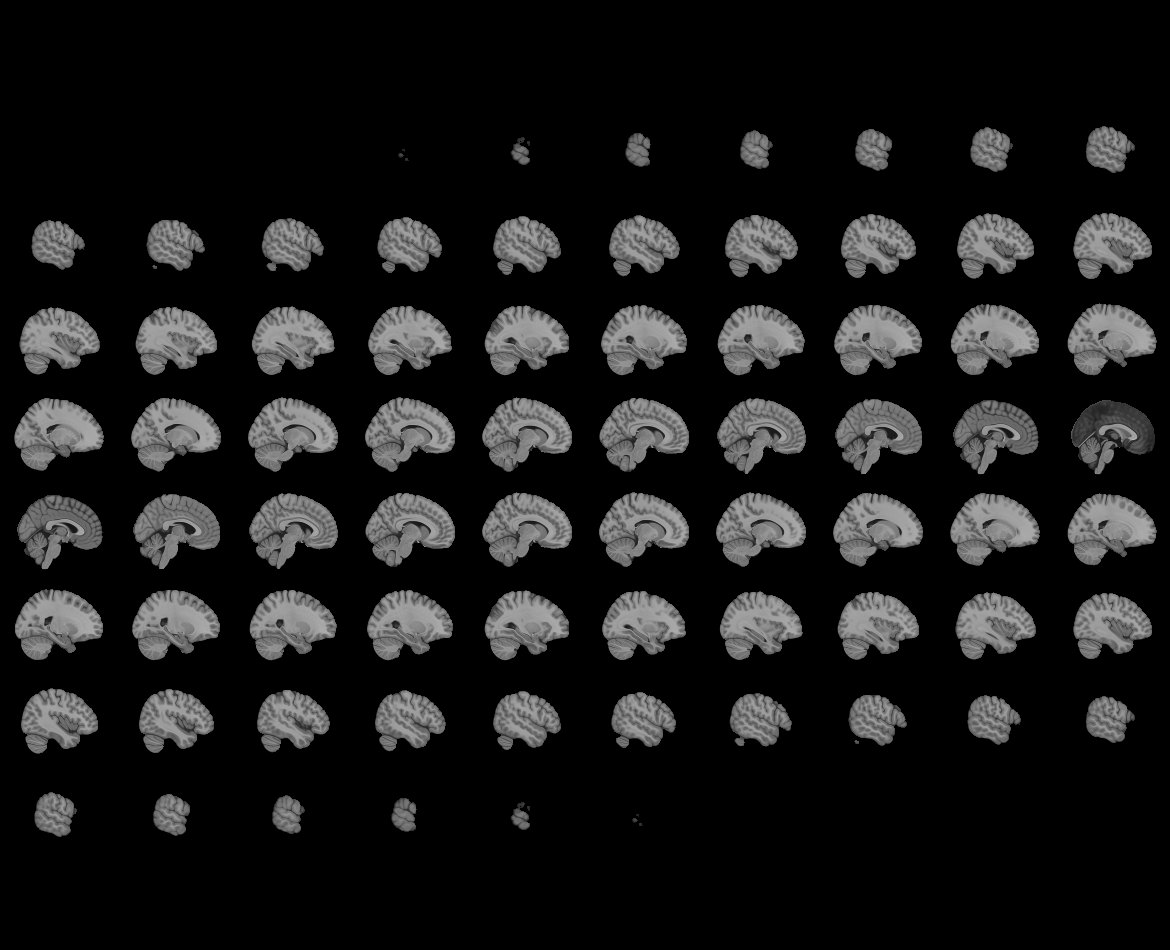
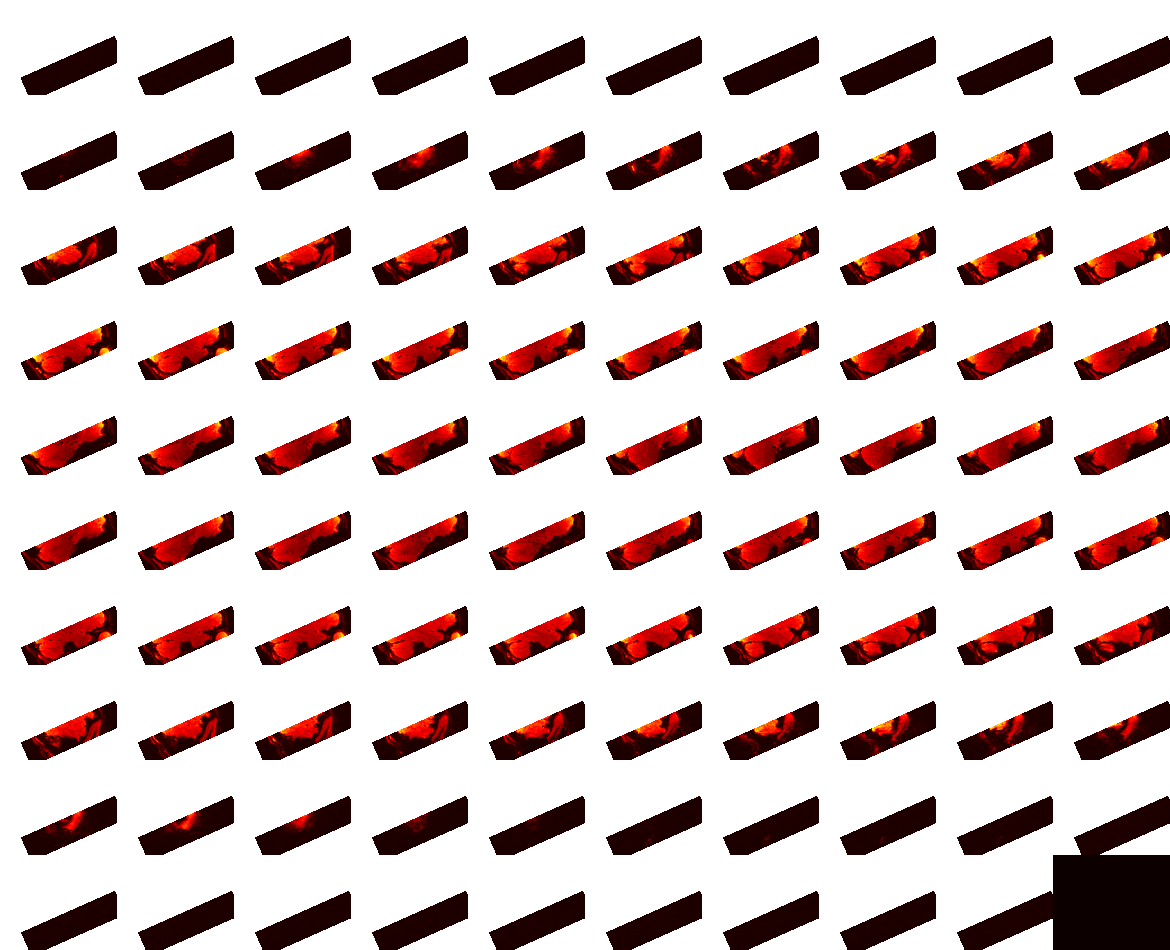

In [12]:
#Example for EDA
subject_id = '01'
run_id = '01'
func_file = os.path.join(data_dir, f'sub-{subject_id}', f'func/sub-{subject_id}_task-odors_run-{run_id}_bold.nii.gz')
output_dir = 'preproc'
os.makedirs(output_dir, exist_ok=True)

#View image before preprocessing
img = nib.load(func_file)
data = img.get_fdata()
if data.ndim == 4:
    img = nib.Nifti1Image(data[:, :, :, data.shape[3] // 2], img.affine)
plotting.view_img(img, threshold=None, title='Raw')


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



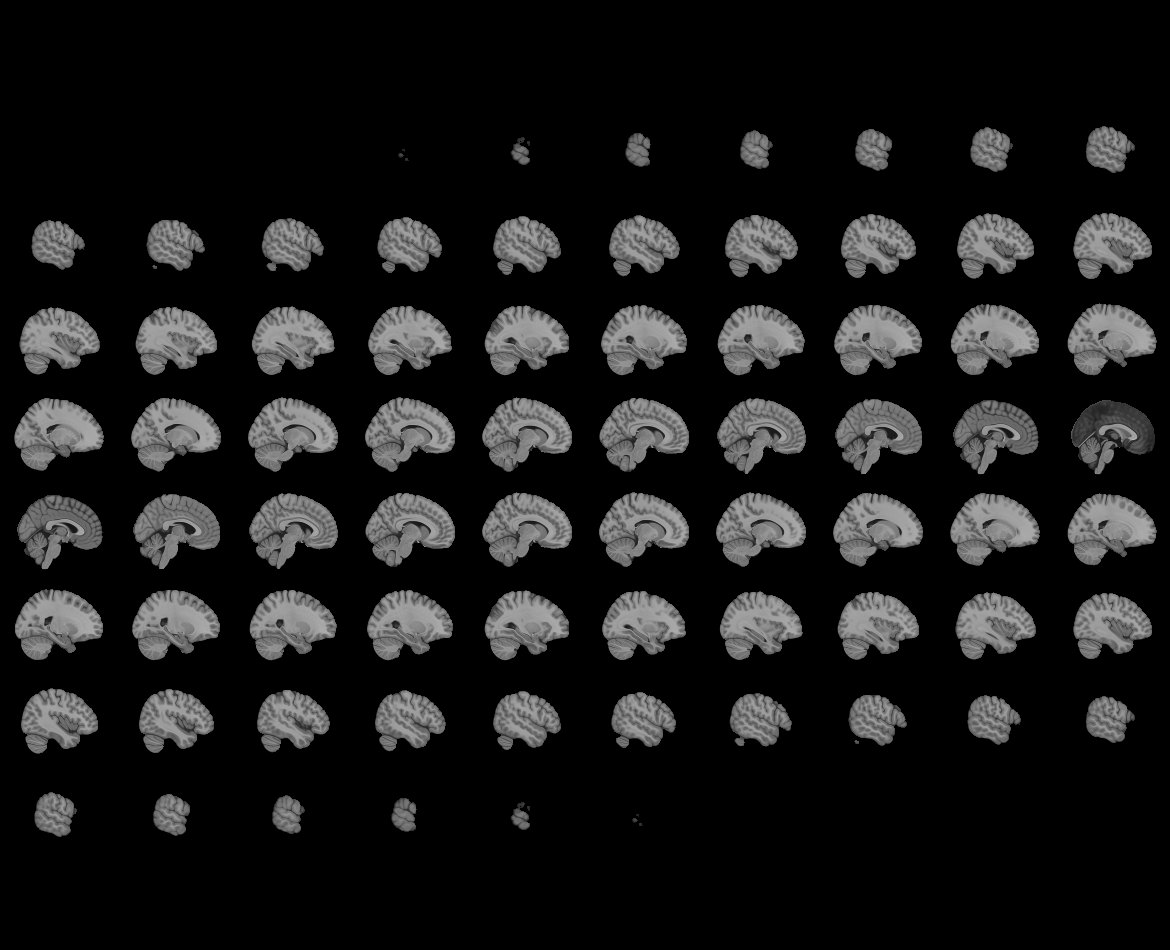
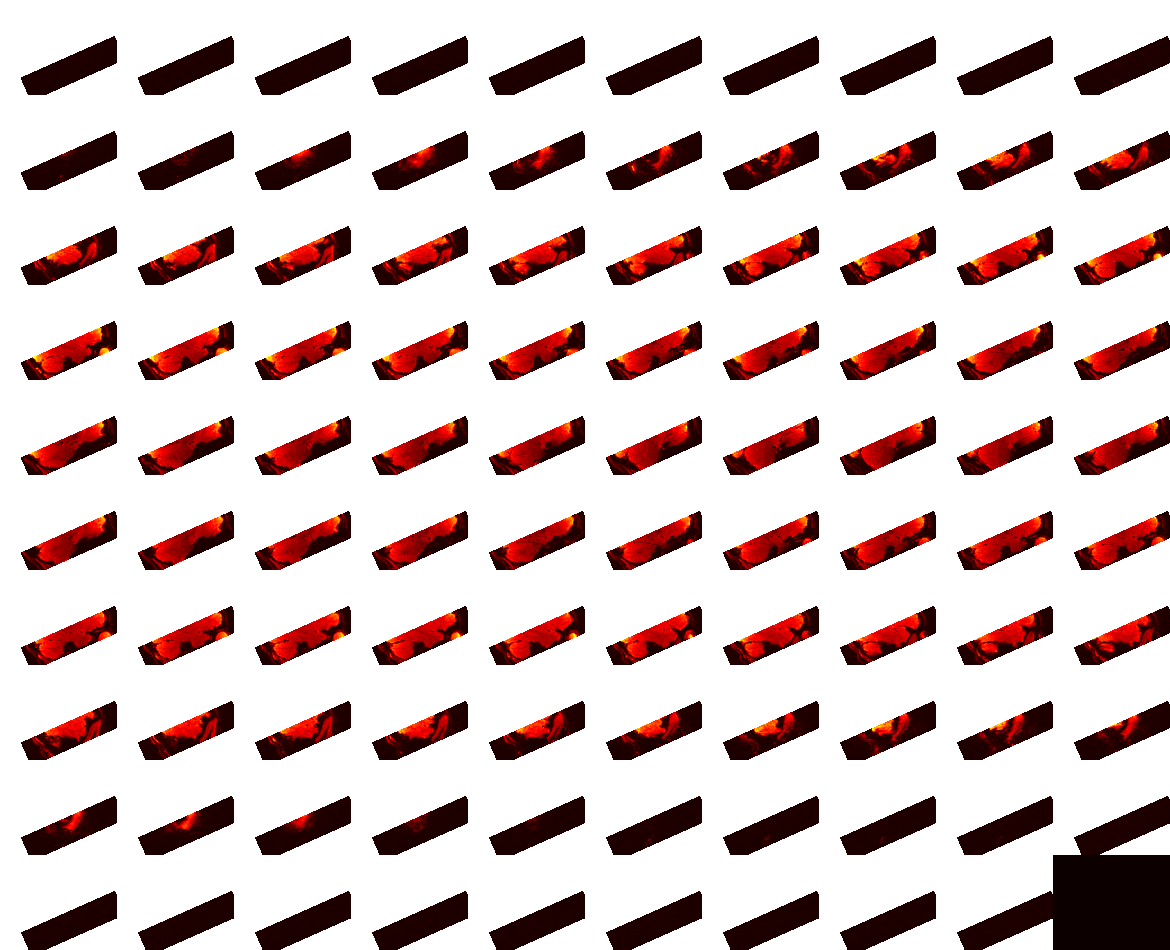

In [11]:
# Step 1: Motion Correction with MCFLIRT
motion_corrected_file = os.path.join(output_dir, f'sub-{subject_id}_task-odors_run-{run_id}_bold_mcf.nii.gz')
mcflirt_cmd = f"mcflirt -in {func_file} -out {motion_corrected_file}"
subprocess.run(mcflirt_cmd, shell=True, check=True)
img = nib.load(motion_corrected_file)
data = img.get_fdata()
if data.ndim == 4:
    img = nib.Nifti1Image(data[:, :, :, data.shape[3] // 2], img.affine)
plotting.view_img(img, threshold=None, title='Motion Corrected')

/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



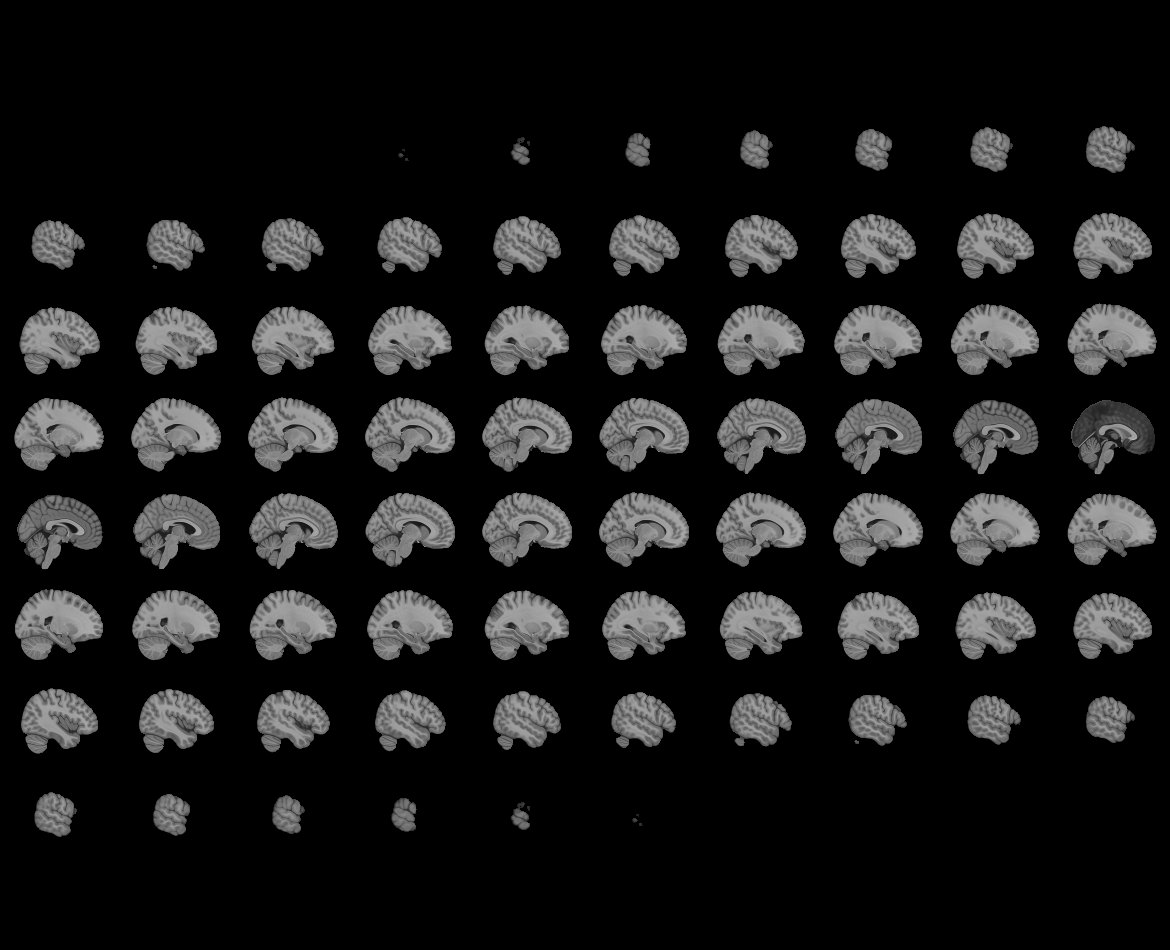
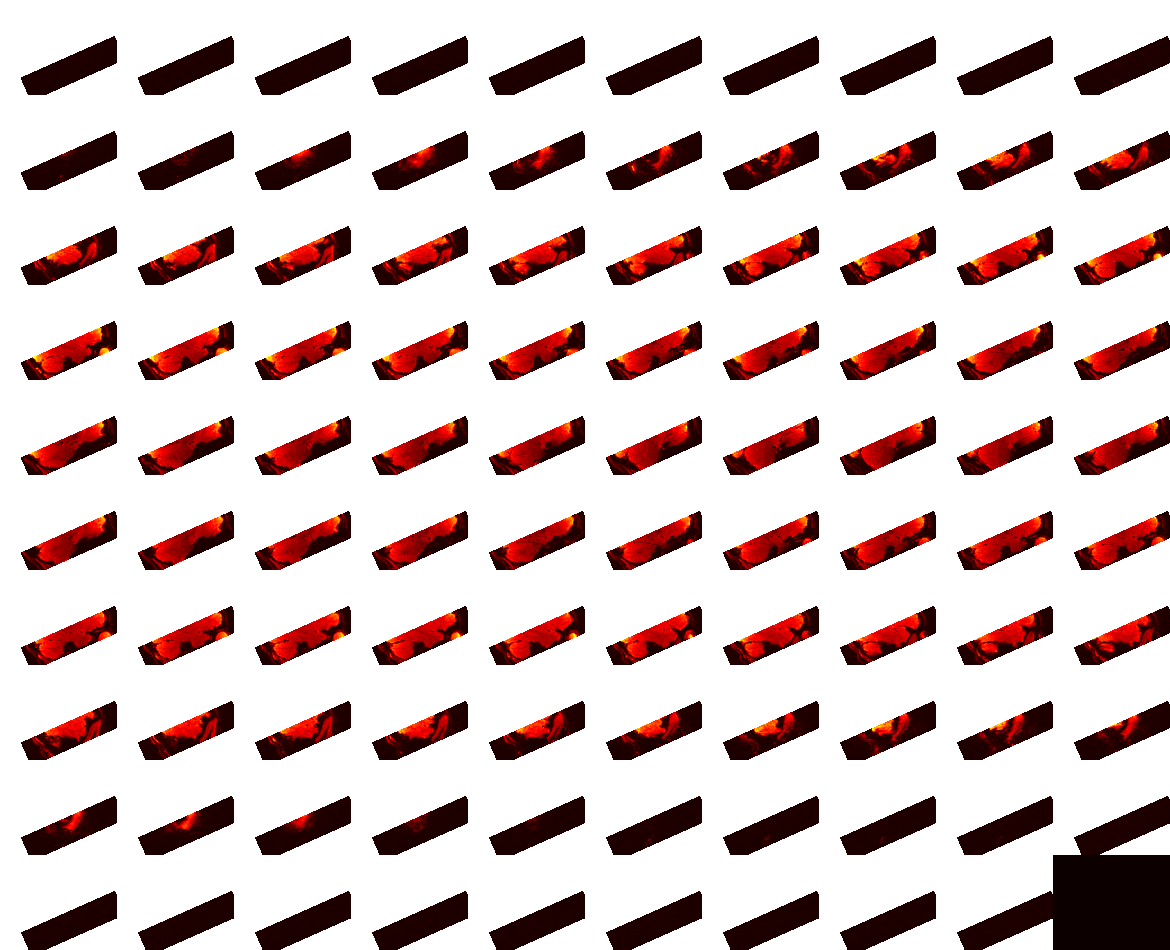

In [ ]:
# Step 2: Extract a single volume from the 4D data for BET
extracted_volume_file = os.path.join(output_dir, f'sub-{subject_id}_task-odors_run-{run_id}_bold_extracted.nii.gz')
extract_volume_cmd = f"fslroi {motion_corrected_file} {extracted_volume_file} 0 1"
subprocess.run(extract_volume_cmd, shell=True, check=True)

# Step 3: Brain Extraction
bet_output_file = os.path.join(output_dir, f'sub-{subject_id}_task-odors_run-{run_id}_bold_brain.nii.gz')
bet_mask_file = os.path.join(output_dir, f'sub-{subject_id}_task-odors_run-{run_id}_bold_brain_mask.nii.gz')
bet_cmd = f"bet {extracted_volume_file} {bet_output_file} -m -g 0.65"
subprocess.run(bet_cmd, shell=True, check=True)

# Step 4: Apply brain mask to the full 4D fMRI data
masked_file = os.path.join(output_dir, f'sub-{subject_id}_task-odors_run-{run_id}_bold_masked.nii.gz')
apply_mask_cmd = f"fslmaths {motion_corrected_file} -mas {bet_mask_file} {masked_file}"
subprocess.run(apply_mask_cmd, shell=True, check=True)
img = nib.load(masked_file)
data = img.get_fdata()
if data.ndim == 4:
    img = nib.Nifti1Image(data[:, :, :, data.shape[3] // 2], img.affine)
plotting.view_img(img, threshold=None, title='After BET')

/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



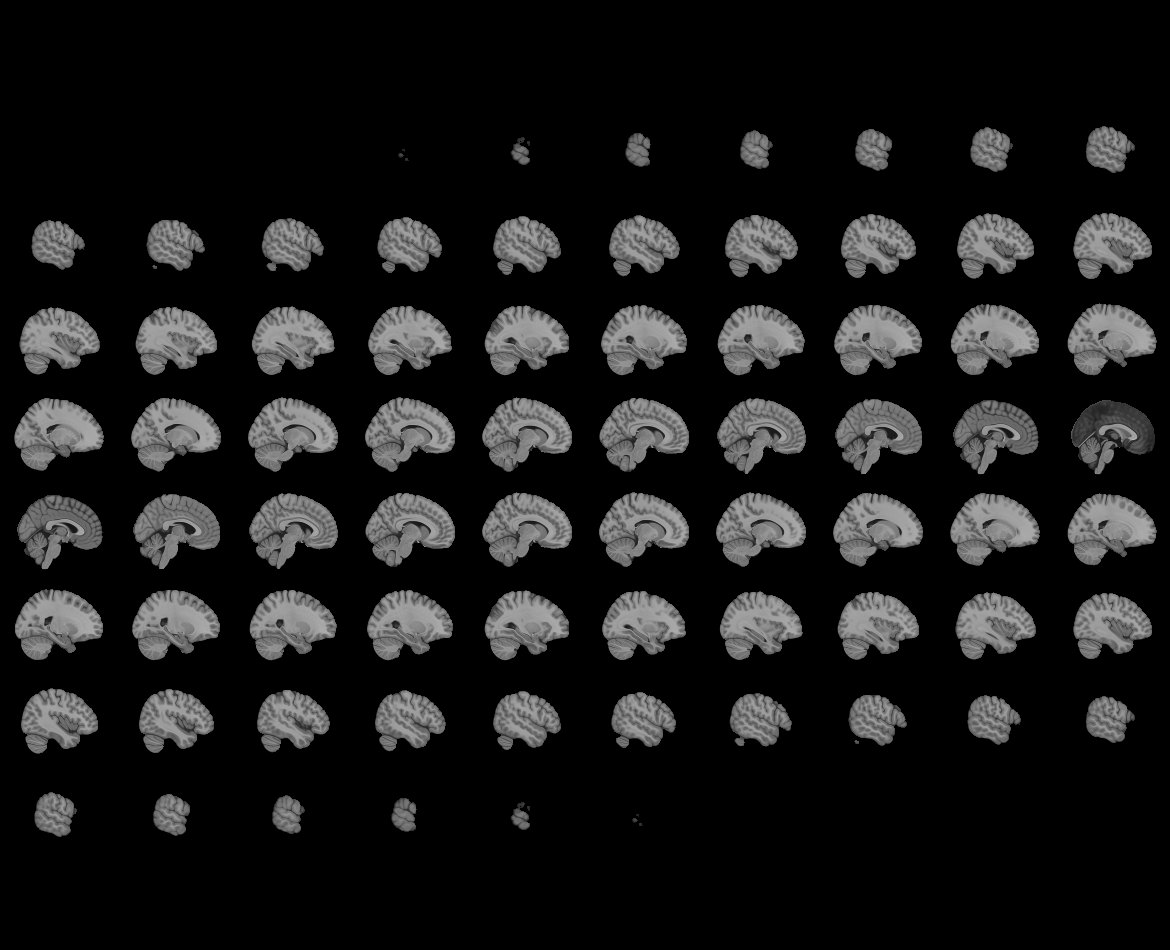
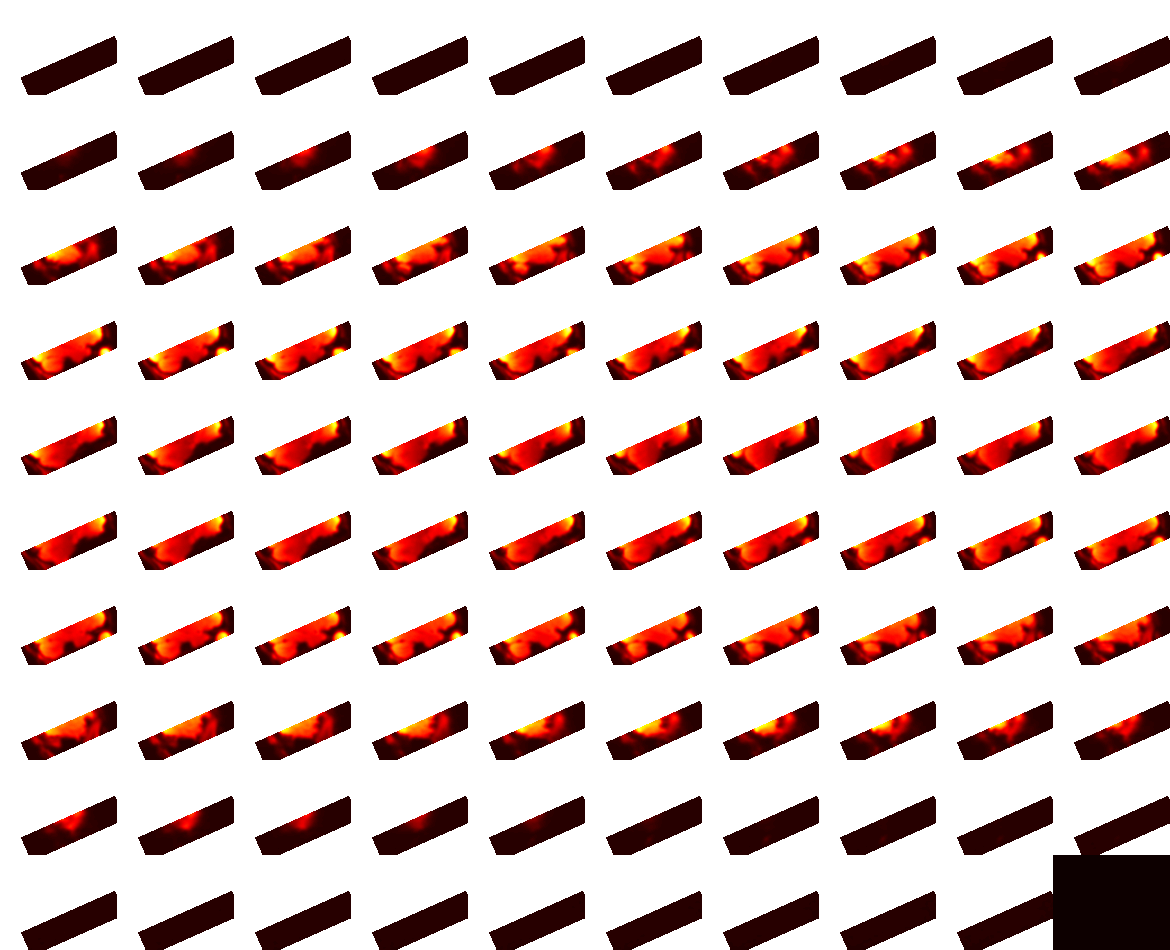

In [ ]:
# Step 5: Spatial Smoothing
smoothed_file = os.path.join(output_dir, f'sub-{subject_id}_task-odors_run-{run_id}_bold_smooth.nii.gz')
smooth_cmd = f"fslmaths {masked_file} -s 2.548 {smoothed_file}"
subprocess.run(smooth_cmd, shell=True, check=True)
img = nib.load(smoothed_file)
data = img.get_fdata()
if data.ndim == 4:
    img = nib.Nifti1Image(data[:, :, :, data.shape[3] // 2], img.affine)
plotting.view_img(img, threshold=None, title='Smoothed')

/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



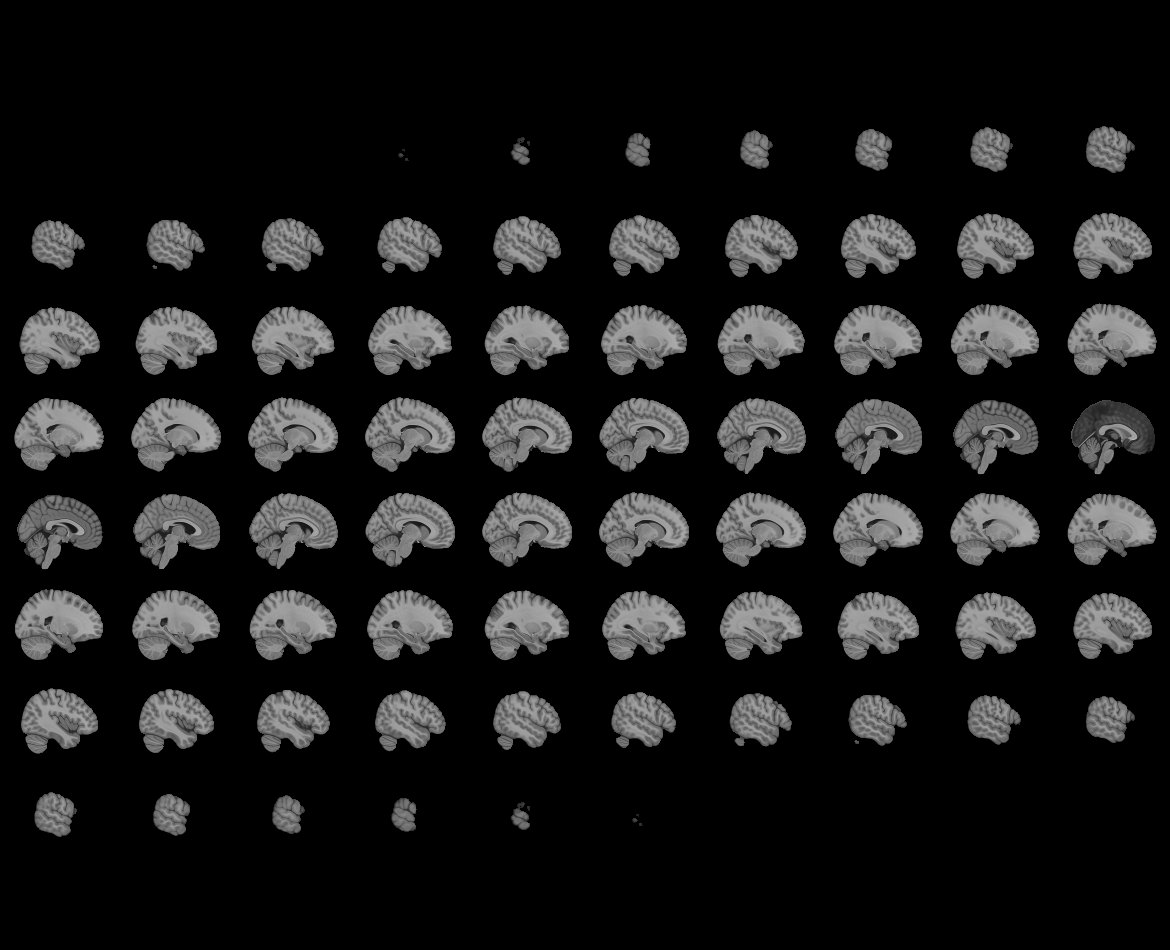
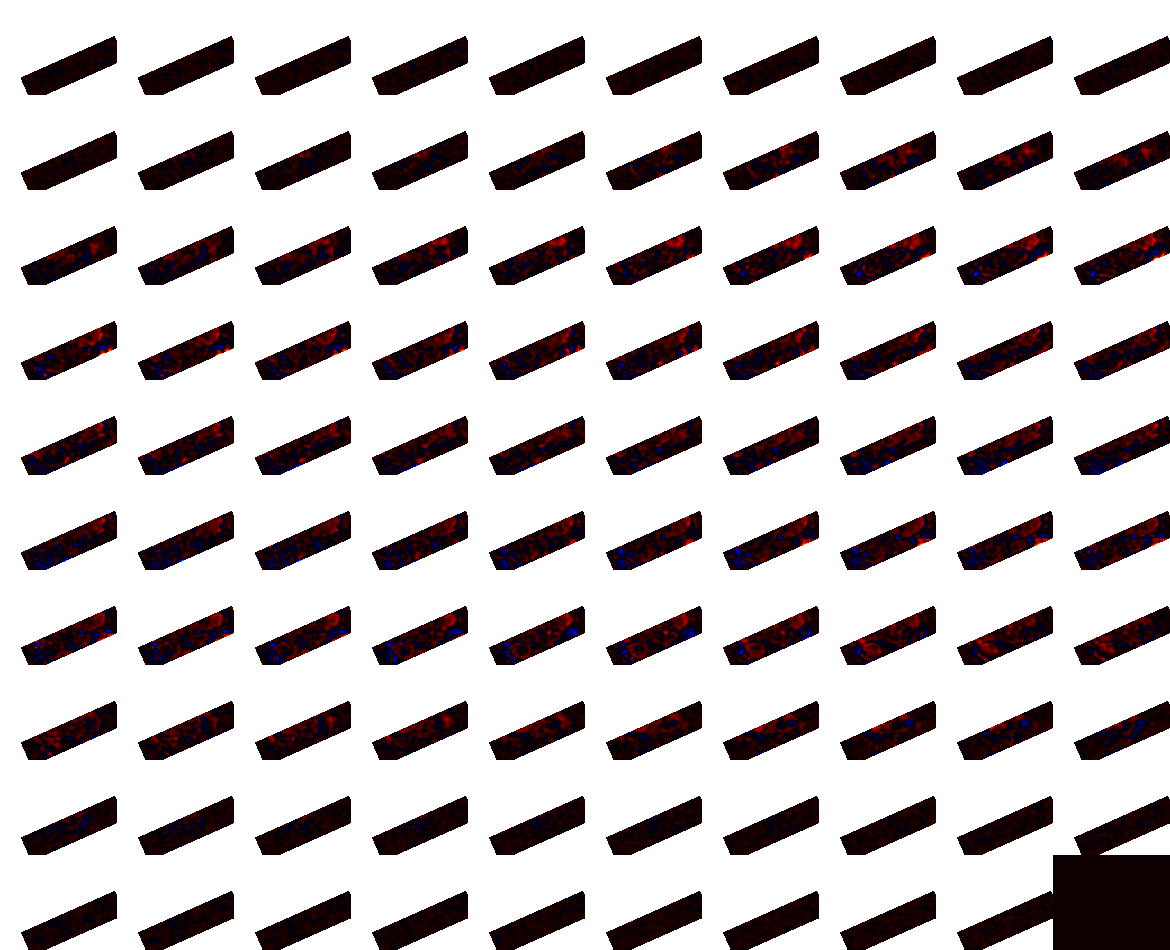

In [ ]:
# Step 6: High-Pass Temporal Filtering
highpassed_file = os.path.join(output_dir, f'sub-{subject_id}_task-odors_run-{run_id}_bold_highpass.nii.gz')
highpass_cmd = f"fslmaths {smoothed_file} -bptf {125 / 2.3548} -1 {highpassed_file}"
subprocess.run(highpass_cmd, shell=True, check=True)
img = nib.load(highpassed_file)
data = img.get_fdata()
if data.ndim == 4:
    img = nib.Nifti1Image(data[:, :, :, data.shape[3] // 2], img.affine)
plotting.view_img(img, threshold=None, title='High-Temporal Pass')

/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



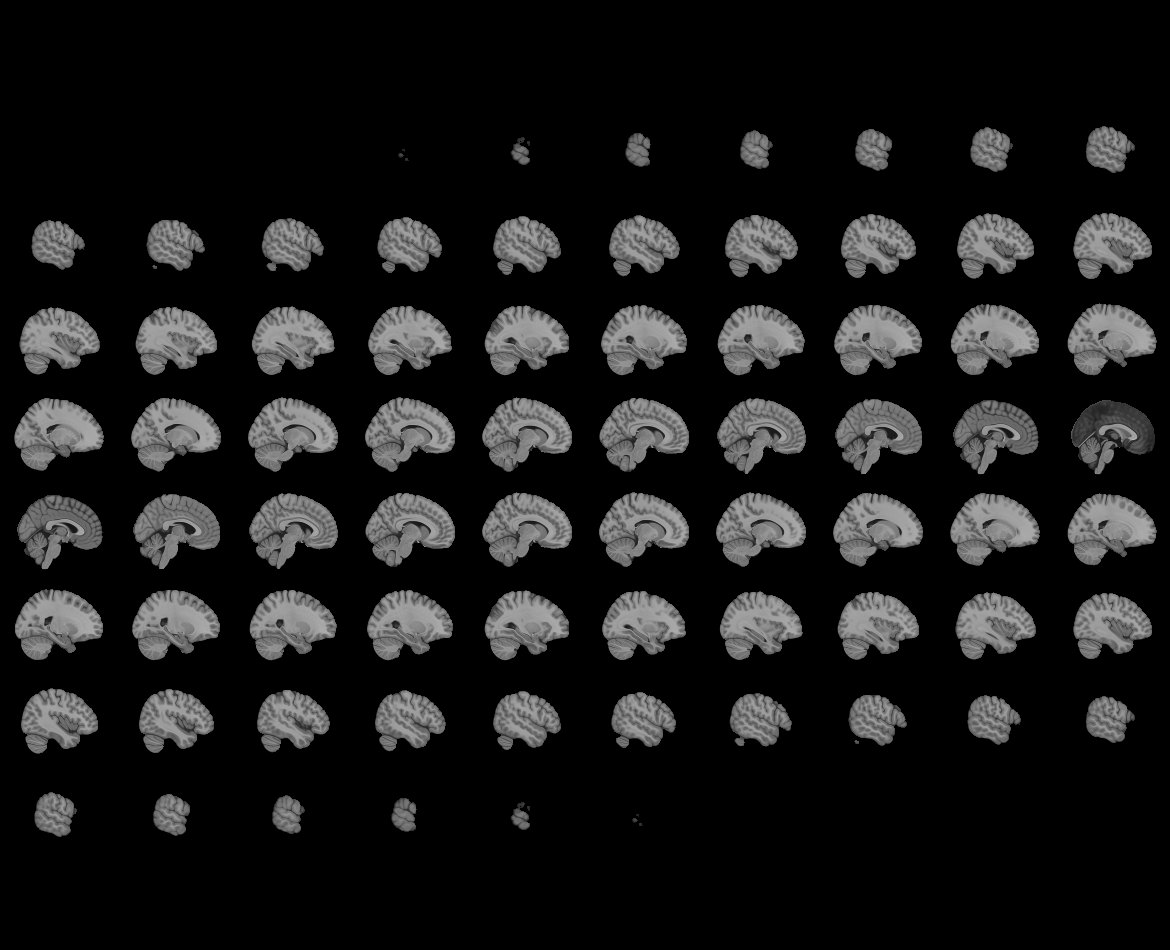
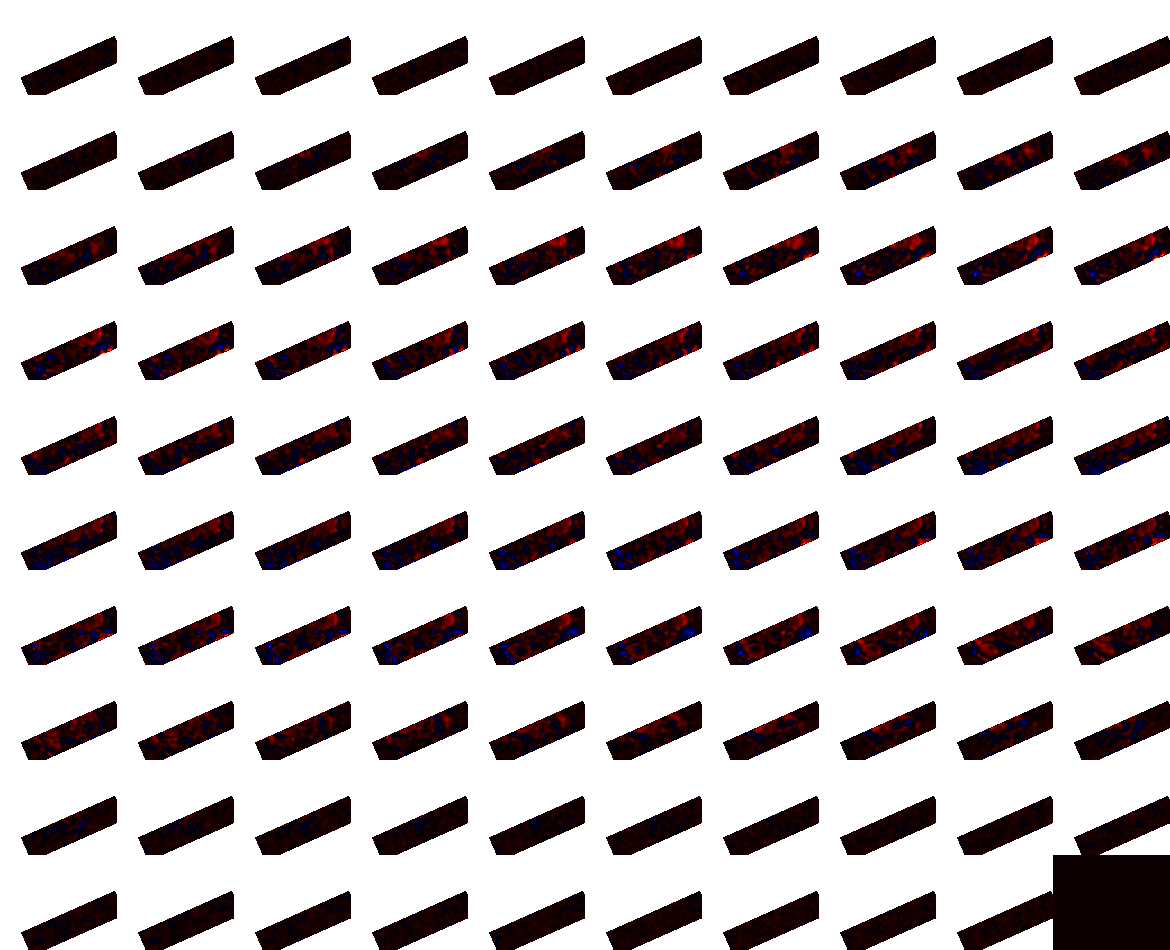

In [ ]:
# Step 7: Compute Mean Image for Nonlinear Registration to MNI Template Space
mean_image_file = os.path.join(output_dir, f'sub-{subject_id}_task-odors_run-{run_id}_bold_mean.nii.gz')
mean_cmd = f"fslmaths {highpassed_file} -Tmean {mean_image_file}"
subprocess.run(mean_cmd, shell=True, check=True)

# Step 8: Resample MNI Template to Match Data FOV
mni_template = '/Users/asaraog/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz'
resampled_template_file = os.path.join(output_dir, f'mni_template_resampled.nii.gz')
resample_cmd = f"flirt -in {mni_template} -ref {mean_image_file} -out {resampled_template_file} -applyisoxfm 2.0"
subprocess.run(resample_cmd, shell=True, check=True)

# Step 9: Nonlinear Registration to MNI Template Space
mni_registered_file = os.path.join(output_dir, f'sub-{subject_id}_task-odors_run-{run_id}_bold_mni.nii.gz')
nonlinear_registration_cmd = f"fnirt --in={mean_image_file} --ref={resampled_template_file} --iout={mni_registered_file} --fout={output_dir}/warp_field --jout={output_dir}/jacobian"
subprocess.run(nonlinear_registration_cmd, shell=True, check=True)

# Step 10: Apply the MNI Registration Transform to All Time Points
mni_registered_all_timepoints_file = os.path.join(output_dir, f'sub-{subject_id}_task-odors_run-{run_id}_bold_preprocessed.nii.gz')
apply_transform_cmd = f"applywarp --ref={resampled_template_file} --in={highpassed_file} --warp={output_dir}/warp_field --out={mni_registered_all_timepoints_file}"
subprocess.run(apply_transform_cmd, shell=True, check=True)
img = nib.load(mni_registered_all_timepoints_file)
data = img.get_fdata()
if data.ndim == 4:
    img = nib.Nifti1Image(data[:, :, :, data.shape[3] // 2], img.affine)
plotting.view_img(img, threshold=None, title='MNI Registered All Timepoints')


## Preprocessing for all subjects and all runs (putting it all together)

In [ ]:
import os
import subprocess

# Define base directories
data_dir = 'ds002185-download'  # Input and output directory

# Get a list of all subject IDs
subject_ids = [d for d in os.listdir(data_dir) if d.startswith('sub-')]
for subject_id in subject_ids:
    if subject_id == 'sub-21':
        print(f"Skipping {subject_id} due to missing functional files.")
        continue
    
    subject_dir = os.path.join(data_dir, subject_id, 'func')
    if not os.path.exists(subject_dir):
        print(f"Skipping {subject_id} due to missing 'func' directory.")
        continue
    
    func_files = [f for f in os.listdir(subject_dir) if f.endswith('_bold.nii.gz')]
    
    for func_file in func_files:
        # Extract run_id from the file name (assuming format sub-01_task-odors_run-01_bold.nii.gz)
        run_id = func_file.split('_')[2].split('-')[1]  # Extract '01' or '02'
        
        if subject_id == 'sub-22' and run_id == '01':
            print(f"Skipping {subject_id} run-{run_id} due to corrupt file.")
            continue
        
        func_file_path = os.path.join(subject_dir, func_file)
        output_dir = subject_dir  # Output in the same place as input

        os.makedirs(output_dir, exist_ok=True)

        # Step 1: Motion Correction
        motion_corrected_file = os.path.join(output_dir, f'{subject_id}_task-odors_run-{run_id}_bold_mcf.nii.gz')
        mcflirt_cmd = f"mcflirt -in {func_file_path} -out {motion_corrected_file}"
        subprocess.run(mcflirt_cmd, shell=True, check=True)

        # Step 2: Extract a single volume from the 4D data for BET
        extracted_volume_file = os.path.join(output_dir, f'{subject_id}_task-odors_run-{run_id}_bold_extracted.nii.gz')
        extract_volume_cmd = f"fslroi {motion_corrected_file} {extracted_volume_file} 0 1"
        subprocess.run(extract_volume_cmd, shell=True, check=True)

        # Step 3: Brain Extraction
        bet_output_file = os.path.join(output_dir, f'{subject_id}_task-odors_run-{run_id}_bold_brain.nii.gz')
        bet_mask_file = os.path.join(output_dir, f'{subject_id}_task-odors_run-{run_id}_bold_brain_mask.nii.gz')
        bet_cmd = f"bet {extracted_volume_file} {bet_output_file} -m -g 0.65"
        subprocess.run(bet_cmd, shell=True, check=True)

        # Step 4: Apply brain mask to the full 4D fMRI data
        masked_file = os.path.join(output_dir, f'{subject_id}_task-odors_run-{run_id}_bold_masked.nii.gz')
        apply_mask_cmd = f"fslmaths {motion_corrected_file} -mas {bet_mask_file} {masked_file}"
        subprocess.run(apply_mask_cmd, shell=True, check=True)
  
        # Step 5: Spatial Smoothing
        smoothed_file = os.path.join(output_dir, f'{subject_id}_task-odors_run-{run_id}_bold_smooth.nii.gz')
        smooth_cmd = f"fslmaths {masked_file} -s 2.548 {smoothed_file}"
        subprocess.run(smooth_cmd, shell=True, check=True)

        # Step 6: High-Pass Temporal Filtering
        highpassed_file = os.path.join(output_dir, f'{subject_id}_task-odors_run-{run_id}_bold_highpass.nii.gz')
        highpass_cmd = f"fslmaths {smoothed_file} -bptf {125 / 2.3548} -1 {highpassed_file}"
        subprocess.run(highpass_cmd, shell=True, check=True)

        # Step 7: Compute Mean Image for Nonlinear Registration to MNI Template Space
        mean_image_file = os.path.join(output_dir, f'{subject_id}_task-odors_run-{run_id}_bold_mean.nii.gz')
        mean_cmd = f"fslmaths {highpassed_file} -Tmean {mean_image_file}"
        subprocess.run(mean_cmd, shell=True, check=True)

        # Step 8: Resample MNI Template to Match Data FOV
        mni_template = '/Users/asaraog/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz'
        resampled_template_file = os.path.join(output_dir, f'mni_template_resampled.nii.gz')
        resample_cmd = f"flirt -in {mni_template} -ref {mean_image_file} -out {resampled_template_file} -applyisoxfm 2.0"
        subprocess.run(resample_cmd, shell=True, check=True)

        # Step 9: Nonlinear Registration to MNI Template Space
        mni_registered_file = os.path.join(output_dir, f'{subject_id}_task-odors_run-{run_id}_bold_mni.nii.gz')
        nonlinear_registration_cmd = f"fnirt --in={mean_image_file} --ref={resampled_template_file} --iout={mni_registered_file} --fout={output_dir}/warp_field --jout={output_dir}/jacobian"
        subprocess.run(nonlinear_registration_cmd, shell=True, check=True)

        # Step 10: Apply the MNI Registration Transform to All Time Points
        mni_registered_all_timepoints_file = os.path.join(output_dir, f'{subject_id}_task-odors_run-{run_id}_bold_preprocessed.nii.gz')
        apply_transform_cmd = f"applywarp --ref={resampled_template_file} --in={highpassed_file} --warp={output_dir}/warp_field --out={mni_registered_all_timepoints_file}"
        subprocess.run(apply_transform_cmd, shell=True, check=True)

        # Clean up intermediate files
        intermediate_files = [
            motion_corrected_file,
            extracted_volume_file,
            bet_output_file,
            bet_mask_file,
            masked_file,
            smoothed_file,
            highpassed_file,
            mean_image_file,
            resampled_template_file,
            mni_registered_file,
            os.path.join(output_dir, f'{subject_id}_task-odors_run-{run_id}_bold_mean_to_mni_template_resampled.log'),
            os.path.join(output_dir, f'{subject_id}_task-odors_run-{run_id}_bold_mean_warpcoef.nii.gz'),
            os.path.join(output_dir, 'warp_field.nii.gz'),
            os.path.join(output_dir, 'jacobian.nii.gz')
        ]
        for file in intermediate_files:
            if os.path.isfile(file):
                os.remove(file)

        print(f"Preprocessing complete for {subject_id}_run-{run_id}! Intermediate files deleted.")


Preprocessing complete for sub-13_run-01! Intermediate files deleted.
Preprocessing complete for sub-13_run-02! Intermediate files deleted.
Preprocessing complete for sub-14_run-01! Intermediate files deleted.
Preprocessing complete for sub-14_run-02! Intermediate files deleted.
Skipping sub-22 run-01 due to corrupt file.
Preprocessing complete for sub-22_run-02! Intermediate files deleted.
Preprocessing complete for sub-15_run-02! Intermediate files deleted.
Preprocessing complete for sub-15_run-01! Intermediate files deleted.
Preprocessing complete for sub-12_run-02! Intermediate files deleted.
Preprocessing complete for sub-12_run-01! Intermediate files deleted.
Preprocessing complete for sub-08_run-01! Intermediate files deleted.
Preprocessing complete for sub-08_run-02! Intermediate files deleted.
Preprocessing complete for sub-01_run-02! Intermediate files deleted.
Preprocessing complete for sub-01_run-01! Intermediate files deleted.
Preprocessing complete for sub-06_run-02! Inte

## Event-handling for positive/negative from each subject and each run

In [5]:
#Example trial_type for one subject and the time to DICOM volume in the matrix
events_df = pd.read_csv('ds002185-download/sub-05/func/sub-05_task-odors_run-02_events.tsv', delimiter='\t')
#The time variable in the matrix refers to dicom volumes, and are found using the MRI repition time or TR of 1.5s
tr = 1.5
events_df['dicom_volume'] = (events_df['onset'] / tr).round().astype(int)
events_df.sort_values(by='onset')

onset  duration     trial_type  response  dicom_volume
10    3.5       1.2         banana         2             2
11   32.3       1.4         banana         1            22
0    61.3       1.8         orange         4            41
5    89.8       1.6  smelly-cheese         1            60
16  121.9       1.2      asafetida         1            81
17  152.4       2.2      asafetida         1           102
1   180.2       1.2         orange         3           120
6   208.4       2.1  smelly-cheese         2           139
12  237.8       2.5         banana         2           159
7   264.7       2.9  smelly-cheese         2           176
18  294.0       2.5      asafetida         1           196
2   323.7       2.1         orange         4           216
13  353.3       2.7         banana         3           236
8   379.5       2.1  smelly-cheese         2           253
14  410.8       1.3         banana         3           274
19  437.5       1.1      asafetida         1           292
3   464.3       1.2         orange         4           310
4   491.8       1.3         orange         3           328
15  522.4       0.8         banana         2           348
9   551.7       1.6  smelly-cheese         2           368

In [3]:
# Define positive and negative response conditions
positive_conditions = ['orange', 'banana']
negative_conditions = ['isovaleric', 'bacon', 'asafetida', 'smelly-cheese']

# TR value
tr = 1.5

# Function to process events, filter by condition, and extract 4D data for 16 DICOM volumes after onset

def process_and_extract_data(file_path, nifti_file, condition_filter):
    # Check if the NIfTI file exists
    if not os.path.exists(nifti_file):
        raise FileNotFoundError(f"NIfTI file not found: {nifti_file}")
    
    # Extract subject and run from the file path
    parts = file_path.split('/')
    subject = parts[1]
    filename = os.path.basename(file_path)  # Get the file name from the path
    run_modality = filename.split('_')[2].replace('_events.tsv', '')  # Extract run_modality as 'run-01' or 'run-02'
    
    # Ensure run_modality is in the format 'run-01' or 'run-02'
    if run_modality not in ['run-01', 'run-02']:
        raise ValueError(f"Unexpected run_modality: {run_modality}")

    # Load the events.tsv file into a DataFrame
    events_df = pd.read_csv(file_path, delimiter='\t')
    
    # Check for 'trial_type' or 'condition' and rename to 'smell'
    if 'trial_type' in events_df.columns:
        events_df.rename(columns={'trial_type': 'smell'}, inplace=True)
    elif 'condition' in events_df.columns:
        events_df.rename(columns={'condition': 'smell'}, inplace=True)
    else:
        print(f"'trial_type' or 'condition' column not found in file: {file_path}. Adding 'smell' column with default value.")
        events_df['smell'] = 'unknown'  # Add 'smell' column with a default value if neither column is found

    # Convert onset to DICOM volume
    events_df['onset'] = events_df['onset'].astype(float)
    events_df['dicom_volume'] = (events_df['onset'] / tr).round().astype(int)

    # Filter based on condition
    filtered_df = events_df[events_df['smell'].isin(condition_filter)].copy()

    if filtered_df.empty:
        return pd.DataFrame()  # Return empty DataFrame if no valid events

    # Load the NIfTI file for the run
    img = nib.load(nifti_file)
    img_data = img.get_fdata()
    
    # Debugging: Check the shape of the NIfTI data
    print(f"Loaded NIfTI file: {nifti_file}, Shape: {img_data.shape}")
    
    # Get the shape of the data
    _, _, _, num_volumes = img_data.shape
    
    # Create a list to store the data for each event
    extracted_data = []

    for _, row in filtered_df.iterrows():
        dicom_start = row['dicom_volume']
        
        # Ensure we don't exceed the number of volumes in the run
        dicom_end = dicom_start + 16
        
        # Check if there are enough volumes to extract
        if dicom_start >= 0 and dicom_end <= num_volumes:
            # Extract the 4D data for the 16 volumes starting from the onset
            data_slice = img_data[:, :, :, dicom_start:dicom_end]
                                 
            # Only add to list if data_slice has at least 16 volumes
            if data_slice.shape[-1] >= 16:
                extracted_data.append({
                    'subject': subject,
                    'run_modality': run_modality,
                    'onset': row['onset'],
                    'dicom_start': dicom_start,
                    'dicom_end': dicom_end,
                    'smell': row['smell'],  # Now using 'smell'
                    'data': data_slice
                })
            else:
                print(f"Skipping event with fewer than 16 volumes: Start = {dicom_start}, End = {dicom_end}, Total Volumes = {num_volumes}")
        else:
            print(f"Skipping event with invalid DICOM volume range: Start = {dicom_start}, End = {dicom_end}, Total Volumes = {num_volumes}")
    
    # Convert the list of dictionaries to a DataFrame
    return pd.DataFrame(extracted_data)

# Process all subjects and runs for positive and negative responses
event_files = glob.glob('ds002185-download/sub-*/func/*_events.tsv')
positive_dfs = []
negative_dfs = []

for file_path in event_files:
    # Assume the corresponding NIfTI file is named similarly to the events file
    nifti_file = file_path.replace('_events.tsv', '_bold_preprocessed.nii.gz')
    
    try:
        positive_df = process_and_extract_data(file_path, nifti_file, condition_filter=positive_conditions)
        negative_df = process_and_extract_data(file_path, nifti_file, condition_filter=negative_conditions)
        
        # Append to the respective list if the DataFrame is not empty
        if not positive_df.empty:
            positive_dfs.append(positive_df)
        if not negative_df.empty:
            negative_dfs.append(negative_df)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Combine all subjects into single DataFrames for positive and negative responses
if positive_dfs:
    positive_combined_df = pd.concat(positive_dfs, ignore_index=True)
else:
    positive_combined_df = pd.DataFrame()

if negative_dfs:
    negative_combined_df = pd.concat(negative_dfs, ignore_index=True)
else:
    negative_combined_df = pd.DataFrame()

# Print total number of events
print(f"Total number of positive events: {len(positive_combined_df)}")
print(f"Total number of negative events: {len(negative_combined_df)}")


Loaded NIfTI file: ds002185-download/sub-13/func/sub-13_task-odors_run-02_bold_preprocessed.nii.gz, Shape: (110, 104, 27, 405)
Loaded NIfTI file: ds002185-download/sub-13/func/sub-13_task-odors_run-02_bold_preprocessed.nii.gz, Shape: (110, 104, 27, 405)
Loaded NIfTI file: ds002185-download/sub-13/func/sub-13_task-odors_run-01_bold_preprocessed.nii.gz, Shape: (110, 104, 27, 414)
Loaded NIfTI file: ds002185-download/sub-13/func/sub-13_task-odors_run-01_bold_preprocessed.nii.gz, Shape: (110, 104, 27, 414)
Loaded NIfTI file: ds002185-download/sub-14/func/sub-14_task-odors_run-01_bold_preprocessed.nii.gz, Shape: (110, 104, 27, 440)
Loaded NIfTI file: ds002185-download/sub-14/func/sub-14_task-odors_run-01_bold_preprocessed.nii.gz, Shape: (110, 104, 27, 440)
Loaded NIfTI file: ds002185-download/sub-14/func/sub-14_task-odors_run-02_bold_preprocessed.nii.gz, Shape: (110, 104, 27, 440)
Loaded NIfTI file: ds002185-download/sub-14/func/sub-14_task-odors_run-02_bold_preprocessed.nii.gz, Shape: (110

In [6]:
# Display the DataFrames
print("Positive Events DataFrame:")
print(positive_combined_df.head())

print("\nNegative Events DataFrame:")
print(negative_combined_df.head())


# Count the number of events per subject in positive_combined_df
positive_event_counts = positive_combined_df['subject'].value_counts()

# Count the number of events per subject in negative_combined_df
negative_event_counts = negative_combined_df['subject'].value_counts()

# Print the znumber of events per subject for positive events
print("Number of positive events per subject:")
for subject, count in positive_event_counts.items():
    print(f"Subject {subject}: {count} positive events")

# Print the number of events per subject for negative events
print("\nNumber of negative events per subject:")
for subject, count in negative_event_counts.items():
    print(f"Subject {subject}: {count} negative events")


Positive Events DataFrame:


  subject run_modality  onset  dicom_start  dicom_end   smell   
0  sub-13       run-02    4.2            3         19  orange  \
1  sub-13       run-02  153.0          102        118  orange   
2  sub-13       run-02  269.7          180        196  orange   
3  sub-13       run-02  383.7          256        272  orange   
4  sub-13       run-02  507.5          338        354  orange   

                                                data  
0  [[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...  
1  [[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...  
2  [[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...  
3  [[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...  
4  [[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...  

Negative Events DataFrame:
  subject run_modality  onset  dicom_start  dicom_end          smell   
0  sub-13       run-02   94.7           63         79  smelly-cheese  \
1  sub-13       run-02  181.7          121        137  smelly-cheese   
2  sub-13       run-02  241.7      

Positive DataFrame columns: Index(['subject', 'run_modality', 'onset', 'dicom_start', 'dicom_end', 'smell',
       'data'],
      dtype='object')
Negative DataFrame columns: Index(['subject', 'run_modality', 'onset', 'dicom_start', 'dicom_end', 'smell',
       'data'],
      dtype='object')
Viewing mean image for the selected negative event


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



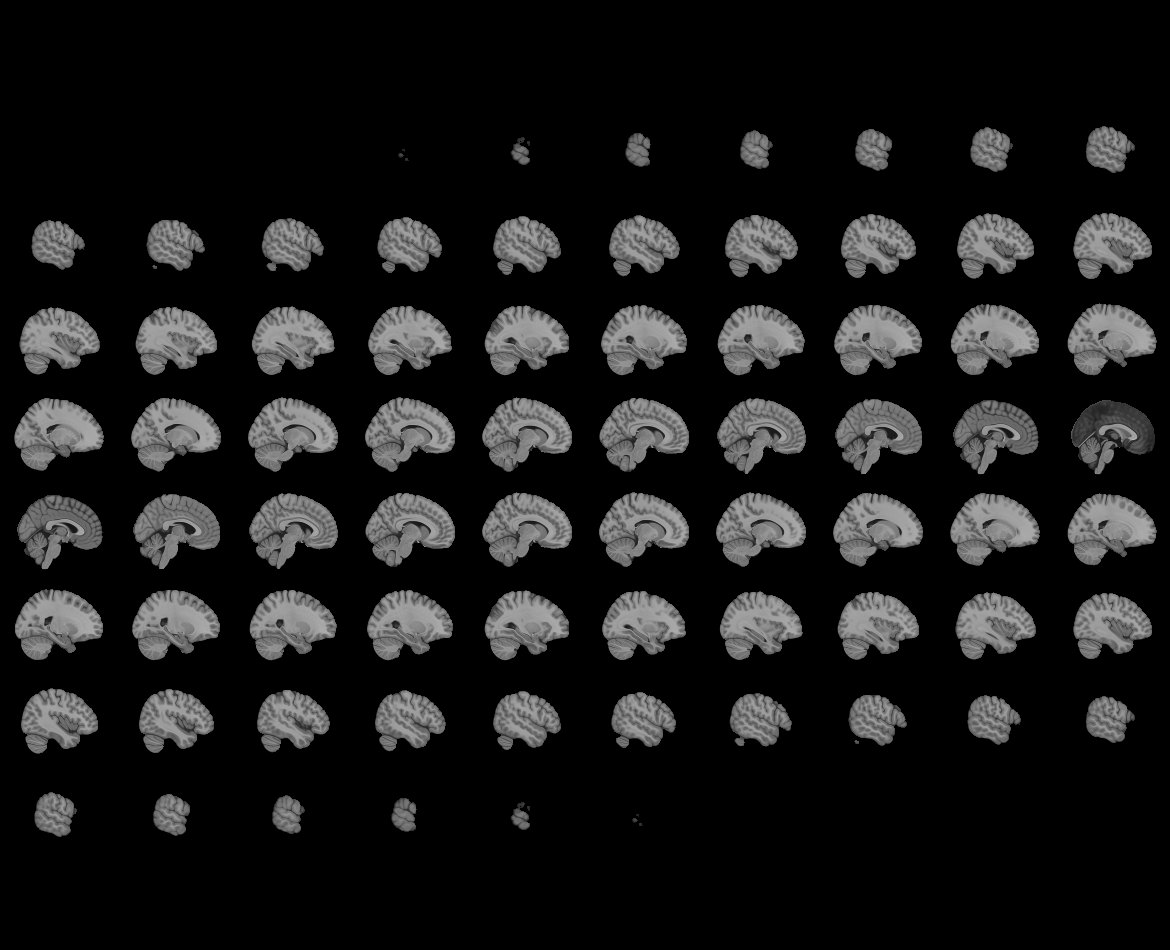
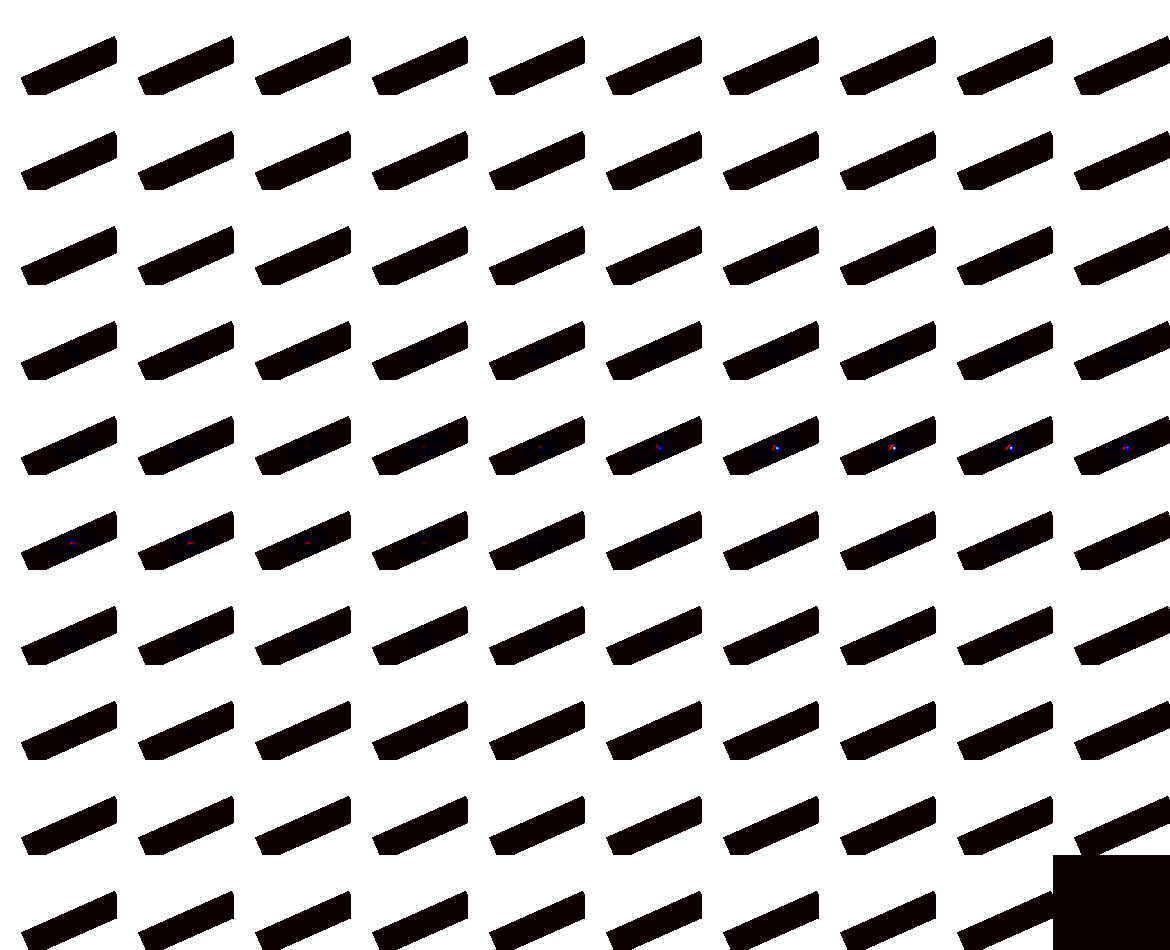

In [8]:
# Print the columns of the DataFrames to confirm
print("Positive DataFrame columns:", positive_combined_df.columns)
print("Negative DataFrame columns:", negative_combined_df.columns)

# Filter the DataFrames based on subject and run_modality
positive_filtered_df = positive_combined_df[(positive_combined_df['subject'] == 'sub-01') & (positive_combined_df['run_modality'] == 'run-01')]
negative_filtered_df = negative_combined_df[(negative_combined_df['subject'] == 'sub-02') & (negative_combined_df['run_modality'] == 'run-01')]

# Check if the filtered DataFrames are not empty and access the first row
if not positive_filtered_df.empty and not negative_filtered_df.empty:
    # Get the data for the first positive and negative events
    positive_data = positive_filtered_df['data'].iloc[0]
    negative_data = negative_filtered_df['data'].iloc[0]

# Define the subject and run
subject = 'sub-01'
run = 'run-01'

# Define the NIfTI file path based on subject and run
nifti_file = f'ds002185-download/{subject}/func/{subject}_task-odors_{run}_bold.nii.gz'

# Check if the file exists
if os.path.exists(nifti_file):
    # Load the NIfTI file
    img = nib.load(nifti_file)
    
    # Extract the affine transformation matrix
    affine = img.affine

# Convert the extracted data to NIfTI images if needed
positive_img = nib.Nifti1Image(positive_data, affine)
negative_img = nib.Nifti1Image(negative_data, affine)

# Compute the mean image using nilearn
mean_positive_img = mean_img(positive_img)
mean_negative_img = mean_img(negative_img)

# View the mean image for an example negative
print("Viewing mean image for the selected negative event")
plotting.view_img(mean_negative_img, threshold=None, title='Mean Image for Selected Negative Event - Subject 01')

Viewing mean image for the selected positive event


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



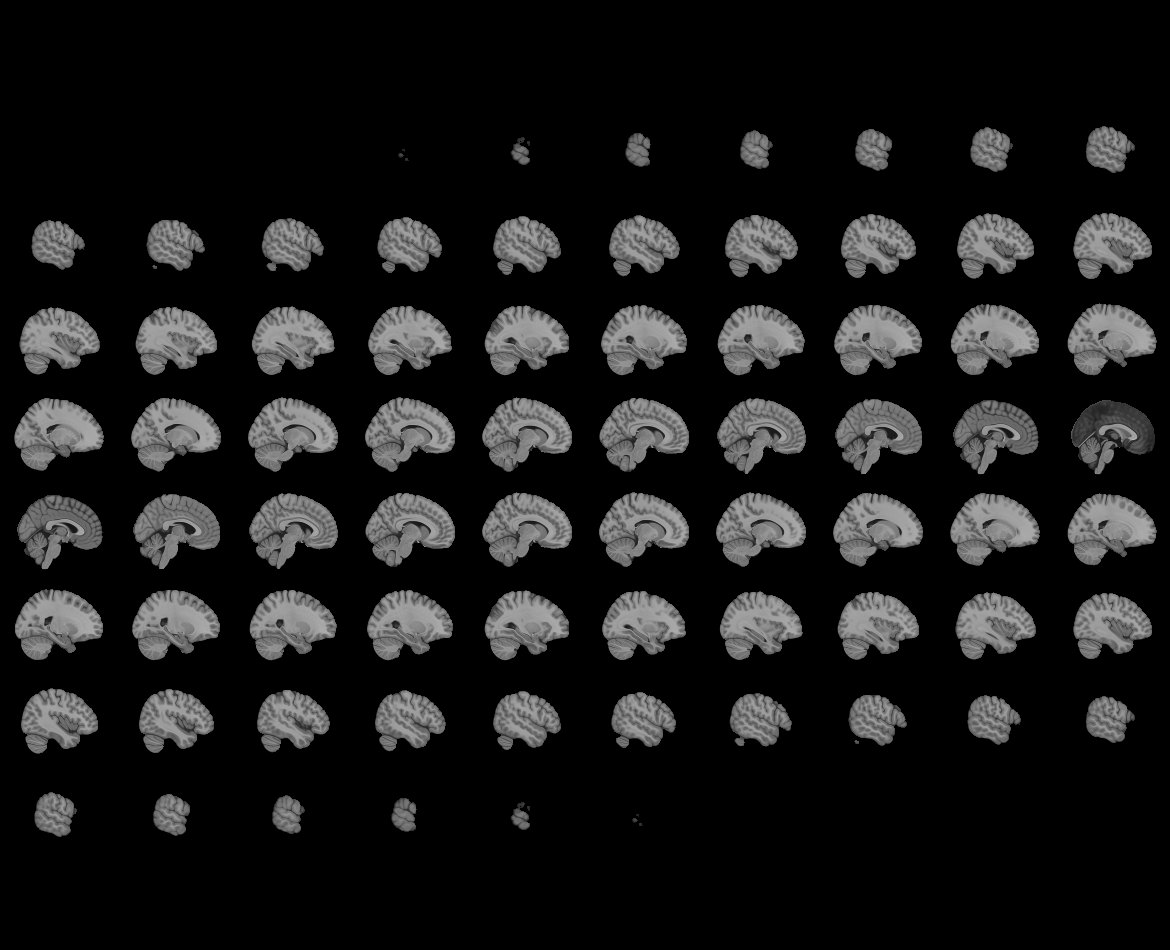
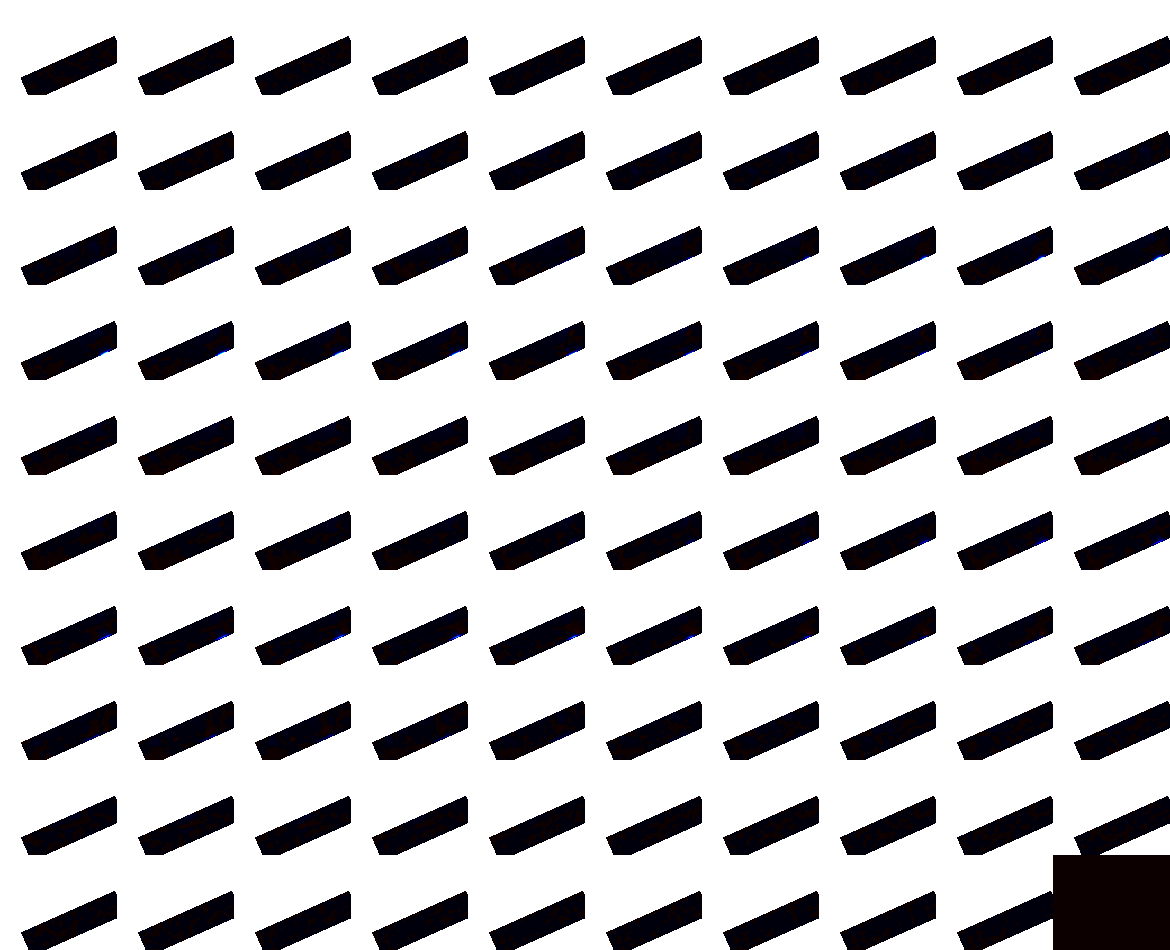

In [9]:
# View the mean image for an example positive
print("Viewing mean image for the selected positive event")
plotting.view_img(mean_positive_img, threshold=None, title='Mean Image for Selected Positive Event - Subject 01')